In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import choices 
from scipy.optimize import brute,minimize
from scipy.integrate import quad
from iminuit import Minuit,cost


In [2]:
def f_max(func,range,*args):
        minus_f= lambda x: -func(x,*args)
        x0= brute(minus_f,[range])[0]
        x0= minimize(minus_f,x0).x[0]
        return func(x0,*args)

def accept_reject(func,range,fmax,size,*args):
        samples= []
        i=0

        while len(samples)<size:
                x= np.random.uniform(*range)
                f_val= func(x,*args)
                accept= choices([True,False],[f_val/fmax,1-f_val/fmax])[0]
                #f_rand= np.random.uniform(0,fmax)
                #if f_rand < f_val :
                if accept:
                        samples.append(x)
                
                i+=1
        
        print(f"Found {len(samples)} samples in {i} iterations")

        
        return np.array(samples)

In [3]:
def d(n,mini,maxi):
    return (maxi**n-mini**n)/n

def row(n,mini,maxi):
    return np.array([d(n,mini,maxi),d(n+1,mini,maxi),d(n+2,mini,maxi)])

def f(x,a,b,norm=False):
    if norm==False:
        return (1 + a*x + b*x**2)
    
def N(mini,maxi,a,b):
    return d(1,mini,maxi)+ a*d(2,mini,maxi)+ b*d(3,mini,maxi)

def pdf(xs,a,b,mini,maxi):

    return np.where((xs>mini)&(xs<maxi),f(xs,a,b)/N(mini,maxi,a,b),0)


def MOME(xs,mini,maxi):
    mu1= np.mean(xs)
    mu2= np.sum((xs**2))/len(xs)
    row0= np.array([1,mu1,mu2])
    row1= row(1,mini,maxi)
    row2= row(2,mini,maxi)
    row3= row(3,mini,maxi)
    det0= np.vstack((row0,row2,row3))
    det0= np.linalg.det(det0)
    deta= np.vstack((row0,row1,row3))
    detb= np.vstack((row0,row1,row2))
    a= -np.linalg.det(deta)/det0
    b= np.linalg.det(detb)/det0

    return a,b
    

In [4]:
a=0.5
b=0.5
x_min=-1
x_max=1

Found 100000 samples in 171152 iterations


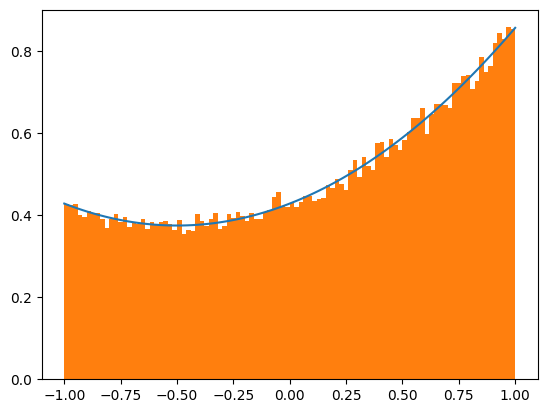

In [5]:
xs= np.linspace(x_min,x_max,100)
fs= f(xs,a,b)
x_samples= accept_reject(f,(x_min,x_max),f(x_max,a,b),100000,a,b)

plt.plot(xs,fs/N(x_min,x_max,a,b))
plt.hist(x_samples,density=True,bins=100)
plt.show()

In [6]:
model= lambda x,a,b: pdf(x,a,b,mini=x_min,maxi=x_max)
nll= cost.UnbinnedNLL(x_samples,model)
mi= Minuit(nll,a=a,b=b)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.313e+05                  │              Nfcn = 33               │
│ EDM = 2.16e-07 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.502   │   0.007   │            │            │         │         │       │
│ 1 │ b    │   0.499   │   0.014   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 5.12e-05  0.05e-3 │
│ b │  0.05e-3 0.000212 │
└───┴───────────────────┘

In [7]:
alpha,beta= MOME(x_samples,x_min,x_max)

In [8]:
print(alpha,beta)

0.5030081082726546 0.503222246891643


In [9]:
data= np.load('mom_data.npy')
x_min=-0.95
x_max=0.95
data.shape

(2000,)

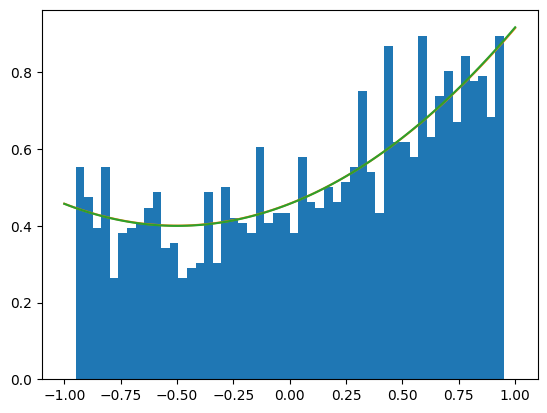

In [10]:
plt.hist(data,density=True,bins=50)
plt.plot(xs,fs/N(x_min,x_max,a,b))
plt.plot(xs,f(xs,alpha,beta)/N(x_min,x_max,alpha,beta))
plt.show()

In [14]:
alpha,beta= MOME(data,x_min,x_max)

In [15]:
print(alpha,beta)

0.5112635621453899 0.49959377213114314


In [13]:
model= lambda x,a,b: pdf(x,a,b,mini=x_min,maxi=x_max)
nll= cost.UnbinnedNLL(data,model)
mi= Minuit(nll,a=a,b=b)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2427                       │              Nfcn = 31               │
│ EDM = 1.55e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.53    │   0.05    │            │            │         │         │       │
│ 1 │ b    │   0.54    │   0.11    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00288  0.0028 │
│ b │  0.0028  0.0126 │
└───┴─────────────────┘